In [6]:
import os
import pandas as pd
import numpy as np
#import utils as ut
from tqdm.notebook import tqdm
#Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import glob
from IPython.core.display_functions import display
import random
import matplotlib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load compound Dataset

In [4]:
save_path = './dataset/'
c30 = pd.read_csv(os.path.join(save_path, 'chembl_30_IC50_10_tids_1000_CPDs.csv'))
c30.rename(columns={'chembl_tid':'Target ID', 'pPot':'pIC50'}, inplace=True)
c30.sort_values(by='Target ID', inplace=True)
c30['Target ID'] = c30['Target ID'].map(lambda x: x.lstrip('CHEMBL').rstrip(''))
c30

,nonstereo_aromatic_smiles,pIC50,chembl_cid,Target ID
5722,COc1ccc(CCc2nc(CCC(=O)NO)cs2)cc1,7.295163,CHEMBL4547600,1865
11011,O=C(C=Cc1cccc(S(=O)(=O)n2ccc3cccnc32)c1)NO,8.283997,CHEMBL3262727,1865
11012,O=C(C=Cc1cccc(S(=O)(=O)n2ccc3ccncc32)c1)NO,6.552842,CHEMBL3262725,1865
11014,O=C(C=Cc1ccccc1)NO,7.657577,CHEMBL154574,1865
5501,COc1ccc(C(=O)Nc2cc(C(=O)NO)ccc2Cl)cc1,6.886057,CHEMBL3797455,1865
...,...,...,...,...
4482,COCCNCc1cc(C2(C)CCSC(N)=N2)c(F)cc1F,5.086186,CHEMBL4092406,4822
10045,NC1=NC(c2ccc(OC(F)F)cc2)(c2cccc(-c3cccnc3F)c2)...,7.519993,CHEMBL1957476,4822
10044,NC1=NC(c2ccc(OC(F)(F)F)cc2)(c2cccc(CCC3CC3)c2)...,6.677781,CHEMBL583888,4822
10058,NC1=NC(c2cccc(NC(=O)c3ccc(Cl)cn3)c2)(C(F)(F)F)...,6.453457,CHEMBL3261066,4822


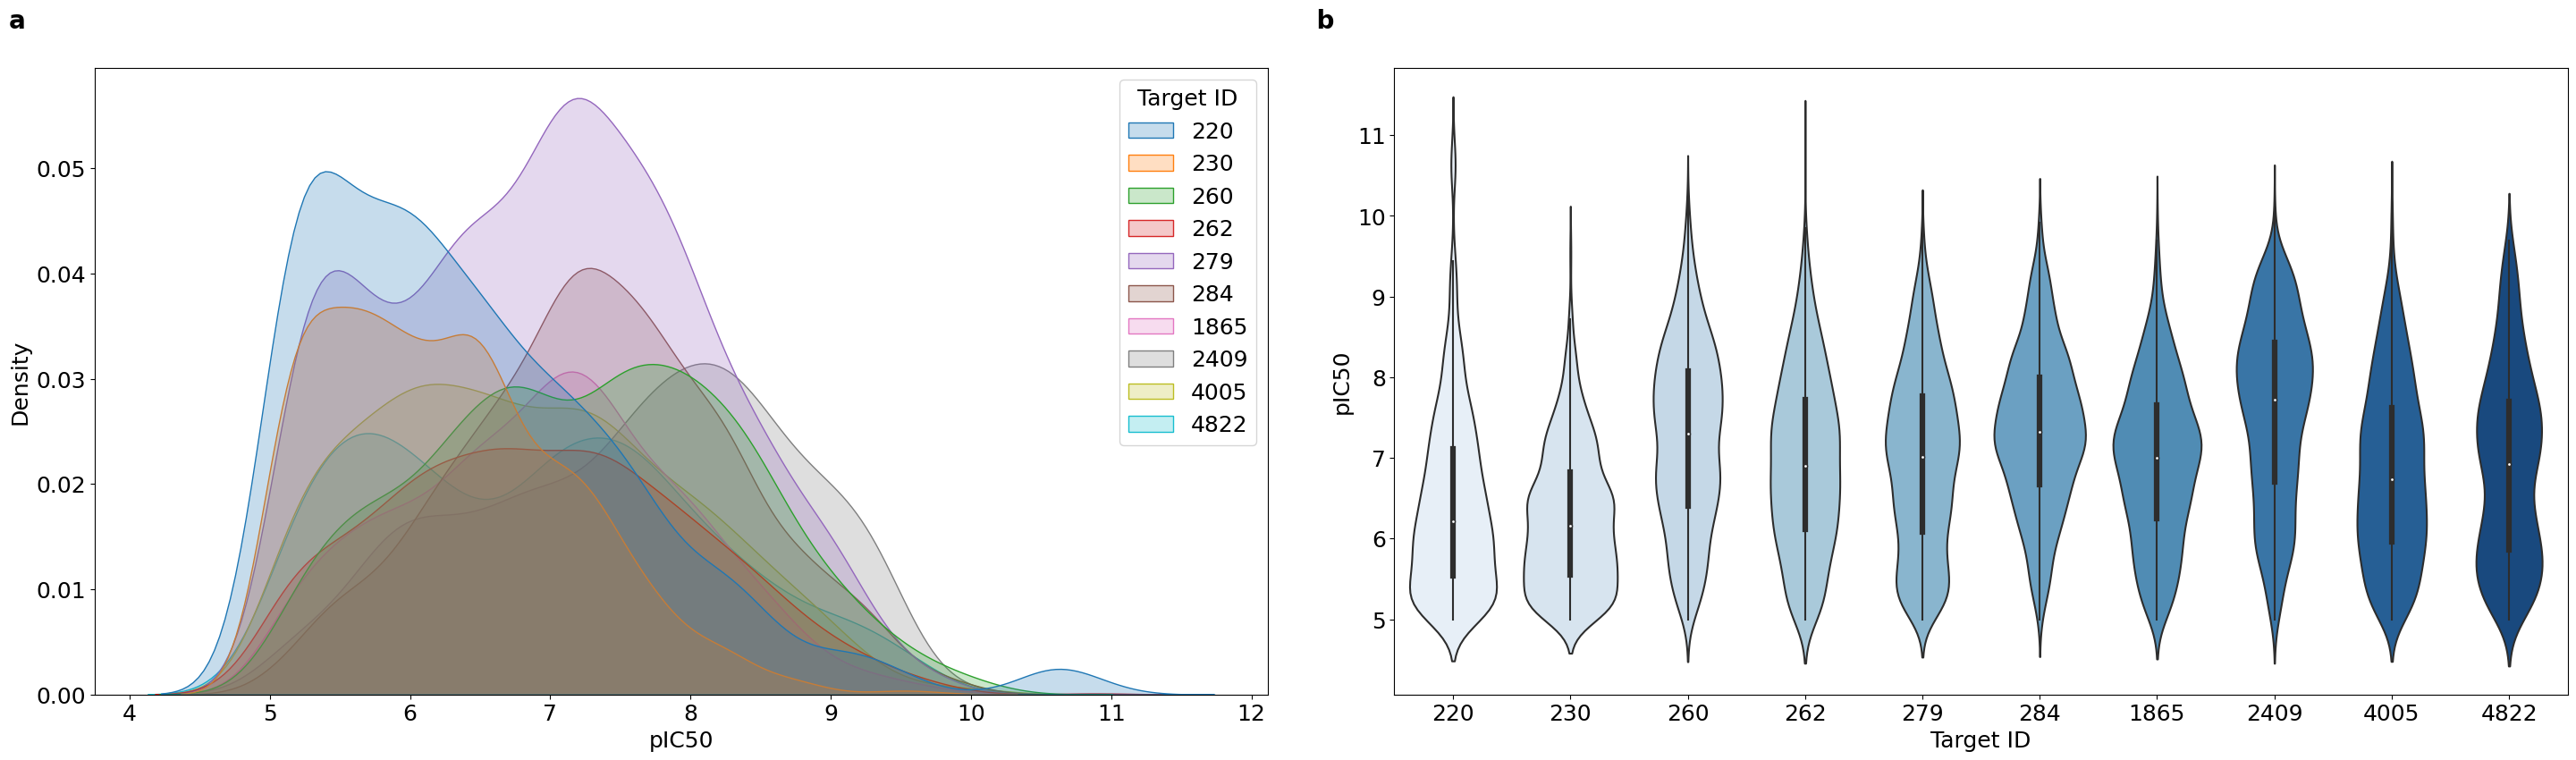

In [10]:
# Plot settings
matplotlib.rcdefaults()
font = {'size': 18}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42

# Sorted dataset
c30_sort = c30.copy()
c30_sort.set_index(keys='Target ID', inplace=True)
c30_sort = c30_sort.loc[['220', '230', '260', '262', '279', '284', '1865', '2409', '4005', '4822']]
c30_sort.reset_index(inplace=True)

hue_order = list(c30['Target ID'].unique())
hue_order.sort(key=float)

# Plot Dataset
fig, axs = plt.subplots(figsize=(30, 10), ncols=2, )
sns.kdeplot(data=c30 , x='pIC50', hue="Target ID", palette="tab10", hue_order=hue_order, fill=True, ax=axs[0])
sns.violinplot(data=c30_sort , y='pIC50', x="Target ID", palette='Blues', ax=axs[1])
plt.suptitle('a                                                                                                                                                      b', fontsize = 20, x=0.27, y=0.9, fontweight='bold')
plt.subplots_adjust(bottom=0.15)
plt.style.use('default')
fig.tight_layout(pad=5.0)


In [22]:
from scipy import sparse
from fingerprints import FoldedMorganFingerprint
from ml_utils import tanimoto_from_sparse

c30 = c30.copy()

regression_tids = c30['Target ID'].unique()[:10]

# Molecular Fingerprints
morgan_radius2 = FoldedMorganFingerprint(radius=2)
morgan_radius2.fit_smiles(c30.nonstereo_aromatic_smiles.tolist())

sim_pot_df = pd.DataFrame()
for target in tqdm(regression_tids):
    regression_db_tid = c30.loc[c30['Target ID'] == target]

    # Constructing ChEMBL Dataset
    fp_matrix = morgan_radius2.transform_smiles(regression_db_tid.nonstereo_aromatic_smiles.tolist())


    similarity = tanimoto_from_sparse(fp_matrix, fp_matrix)

    pot_list = np.array(regression_db_tid.pIC50.tolist())

    delta_pot = []
    for pot in pot_list:
        delta_list = []
        for pot_2 in pot_list:
            delta = abs(pot-pot_2)
            delta_list.append(delta)
        delta_pot.append(np.array(delta_list))

    delta_array = np.array(delta_pot)


    def ignore_dig(matrix):
        dpot=[]
        for i, d_pot in enumerate(matrix):
            diag_idx = (np.arange(i+1,))
            d_pot[diag_idx] = np.nan
            dpot.append(d_pot)
        return np.array(dpot)


    sim_nodiag = np.ravel(ignore_dig(similarity))
    pot_nodiag = np.ravel(ignore_dig(delta_array))

    sim_nodiag = sim_nodiag[~np.isnan(sim_nodiag)]
    pot_nodiag = pot_nodiag[~np.isnan(pot_nodiag)]

    sim_df = pd.DataFrame(list(zip([target]*len(sim_nodiag), sim_nodiag, pot_nodiag)), columns=['Target ID', 'Similarity', 'Δ pIC50'])

    sim_pot_df = pd.concat([sim_pot_df, sim_df])

    #Plot distribuition
    plot =False
    if plot:
        font = {'size': 12}
        plt.rc('font', **font)

        g1 = sns.jointplot(x="Similarity", y="Δ pIC50", data=sim_pot_df.loc[sim_pot_df['Target ID'] == f'{target}'],
                           kind="hist", space=0, hue="Target ID", ylim=(0,6), color='b')

        plt.show()

display(sim_pot_df)

  0%|          | 0/10 [00:00<?, ?it/s]

,Target ID,Similarity,Δ pIC50
0,1865,0.139241,0.988833
1,1865,0.151899,0.742321
2,1865,0.163636,0.362414
3,1865,0.278689,0.409107
4,1865,0.200000,1.313901
...,...,...,...
622165,4822,0.177083,1.066536
622166,4822,0.290698,0.917933
622167,4822,0.191489,0.224323
622168,4822,0.222222,0.075721
